In [1]:
import numpy as np
import pandas as pd
import os
import random
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    ConfusionMatrixDisplay, 
    RocCurveDisplay,
    precision_recall_curve,
    f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import loguniform, randint
import lightgbm as lgb
import catboost as cb
import shap
import joblib
from sklearn.preprocessing import LabelEncoder
import datetime
import optuna

c:\Users\amans\Desktop\FODS PROJECT\fods\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print("Downloading dataset from Kaggle...")
!kaggle datasets download -d wordsforthewise/lending-club
print("Download complete.")

In [ ]:
import zipfile

# Define the path to your zip file
zip_file_path = 'lending-club.zip'

# Define the directory where you want to extract the files (e.g., ".")
extract_to_directory = 'extracted_dataset'

# Open and extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print(f"Successfully unzipped '{zip_file_path}' to '{extract_to_directory}'")

In [ ]:
# --- Load Data ---
# We will load the full data, sort by date, and take the most recent 500k. This is better than a small random sample for time-series data.
extract_dir = 'extracted_dataset'
csv_file_name = 'accepted_2007_to_2018Q4.csv.gz'
data_path = os.path.join(extract_dir, csv_file_name)

if os.path.exists(data_path):
    print("Loading full dataset to get most recent records...")
    # Only load necessary columns to save memory
    cols_to_load = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
                    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
                    'issue_d', 'loan_status', 'purpose', 'dti', 'delinq_2yrs', 
                    'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 
                    'revol_util', 'total_acc', 'initial_list_status', 'application_type', 
                    'mort_acc', 'pub_rec_bankruptcies', 'tax_liens',
                    'recoveries', 'collection_recovery_fee'] # Load leaky feats to drop
    
    # Parse 'issue_d' during load
    df_full = pd.read_csv(data_path, 
                          usecols=cols_to_load, 
                          parse_dates=['issue_d'], 
                          low_memory=False)
    
    print(f"Full dataset loaded with {len(df_full)} rows.")

    # --- 1. Fix Data Leakage ---
    # Drop features that are only known AFTER a default
    leaky_features = ['recoveries', 'collection_recovery_fee']
    df_full = df_full.drop(columns=leaky_features)
    print(f"Dropped leaky features: {leaky_features}")
    
    # --- 2. Re-evaluate Sampling ---
    # Sort by date and take the most recent 500,000 loans
    df_full = df_full.sort_values(by='issue_d', ascending=False)
    df_sample = df_full.head(500000).copy()
    print(f"Selected most recent 500,000 records for modeling.")
    
else:
    print(f"Error: Data file not found at {data_path}. Check extraction step.")

# --- 3. Target Variable Creation ---
print("\nCreating target variable 'is_default'...")
good_status = [
    'Fully Paid', 
    'Does not meet the credit policy. Status:Fully Paid'
]
bad_status = [
    'Charged Off', 
    'Default', 
    'Does not meet the credit policy. Status:Charged Off'
]

status_map = {status: 0 for status in good_status}
status_map.update({status: 1 for status in bad_status})

df_sample['is_default'] = df_sample['loan_status'].map(status_map)
df_model = df_sample.dropna(subset=['is_default']).copy()
df_model['is_default'] = df_model['is_default'].astype(int)

# --- 4. Initial Data Inspection ---
print("\n--- Sample Data Loaded Successfully ---")
print(f"Shape of the loaded data: {df_model.shape}")
print(df_model.head())
print("\nDistribution of 'loan_status' in sample:")
print(df_model['loan_status'].value_counts())
print("\nDistribution of the binary target variable 'is_default':")
print(df_model['is_default'].value_counts())
print("\nPercentage distribution:")
print(df_model['is_default'].value_counts(normalize=True) * 100)

Loading full dataset to get most recent records...


C:\Users\amans\AppData\Local\Temp\ipykernel_492\772908014.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_full = pd.read_csv(data_path,


Full dataset loaded with 2260701 rows.
Dropped leaky features: ['recoveries', 'collection_recovery_fee']
Selected most recent 500,000 records for modeling.

Creating target variable 'is_default'...

--- Sample Data Loaded Successfully ---
Shape of the loaded data: (57538, 28)
         loan_amnt        term  int_rate  installment grade sub_grade  \
1379311    23500.0   60 months     13.56       541.46     C        C1   
1379192    17000.0   60 months     13.56       391.70     C        C1   
1379162    22000.0   60 months     20.89       593.82     D        D4   
1379168    25000.0   60 months     27.27       767.43     E        E5   
1379222    30000.0   36 months     18.94      1098.78     D        D2   

        emp_length home_ownership  annual_inc verification_status  ...  \
1379311  10+ years           RENT    62600.00        Not Verified  ...   
1379192  10+ years       MORTGAGE    95000.00     Source Verified  ...   
1379162        NaN       MORTGAGE    30947.52            Verif


Starting EDA...


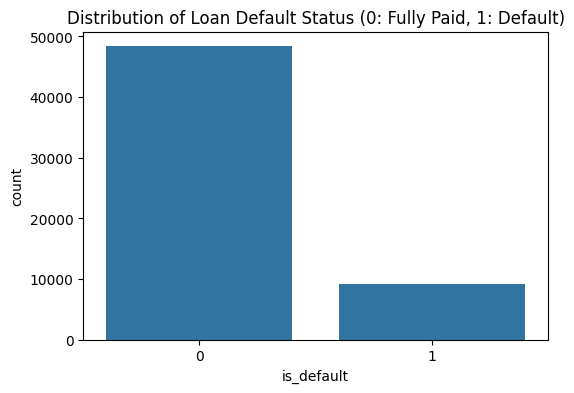

Overall Default Rate: 15.90%


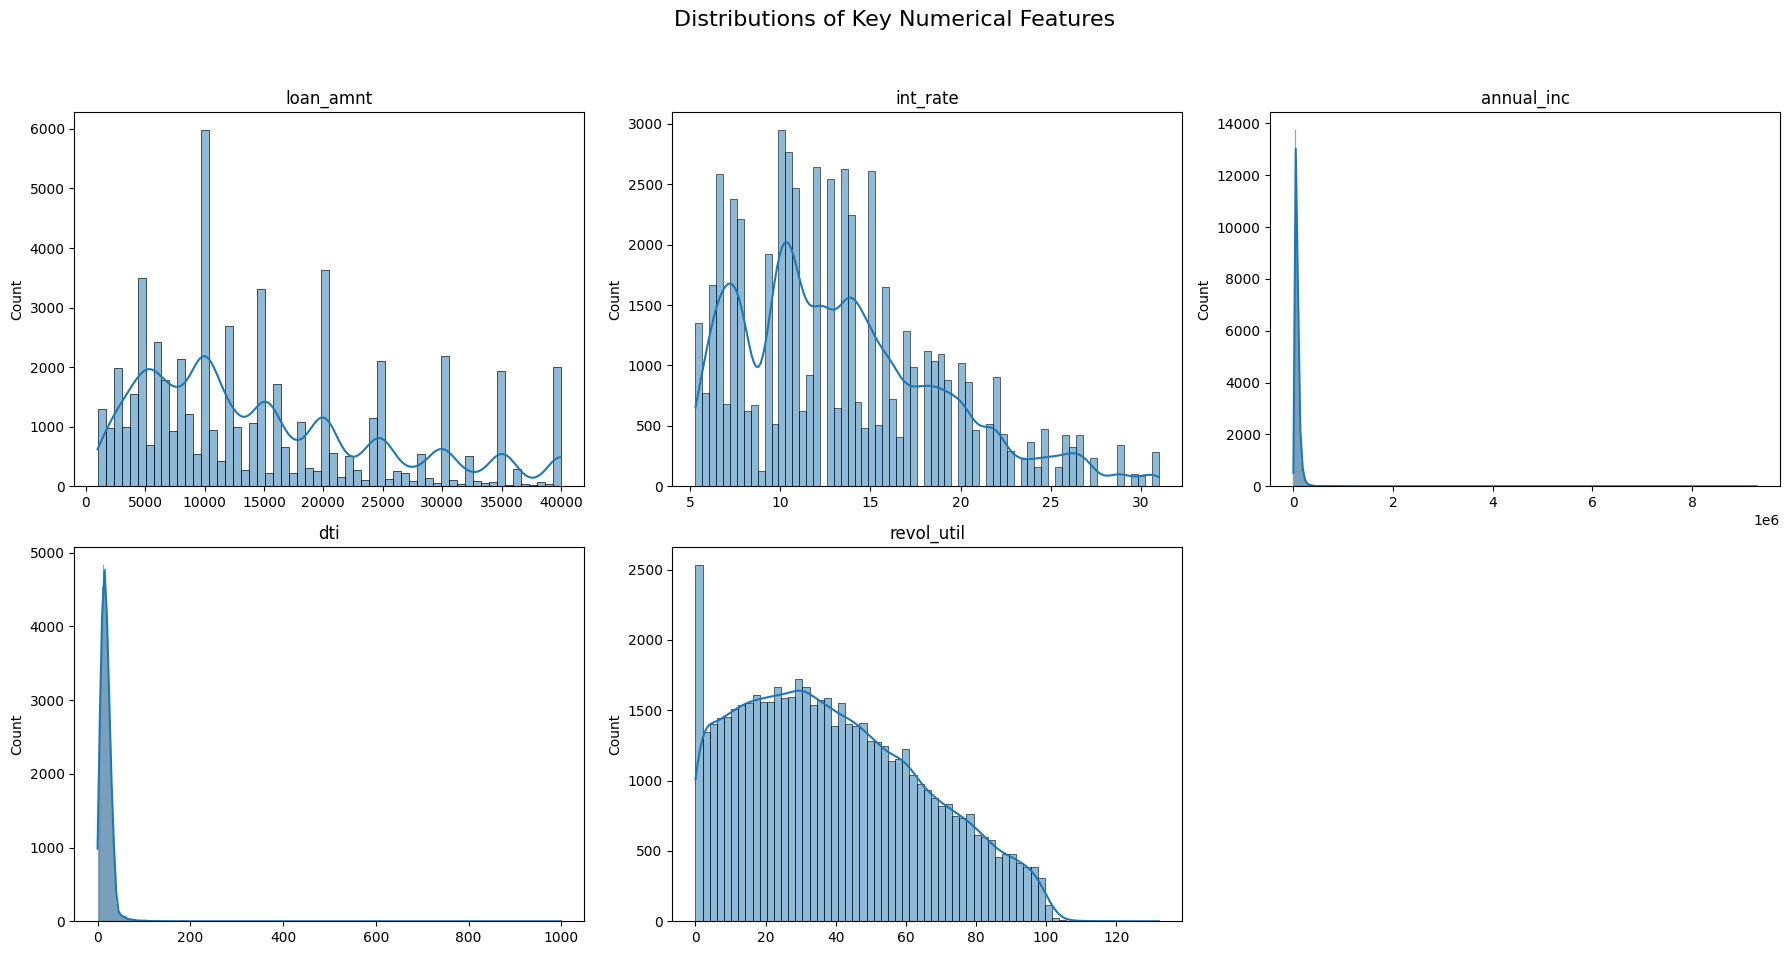

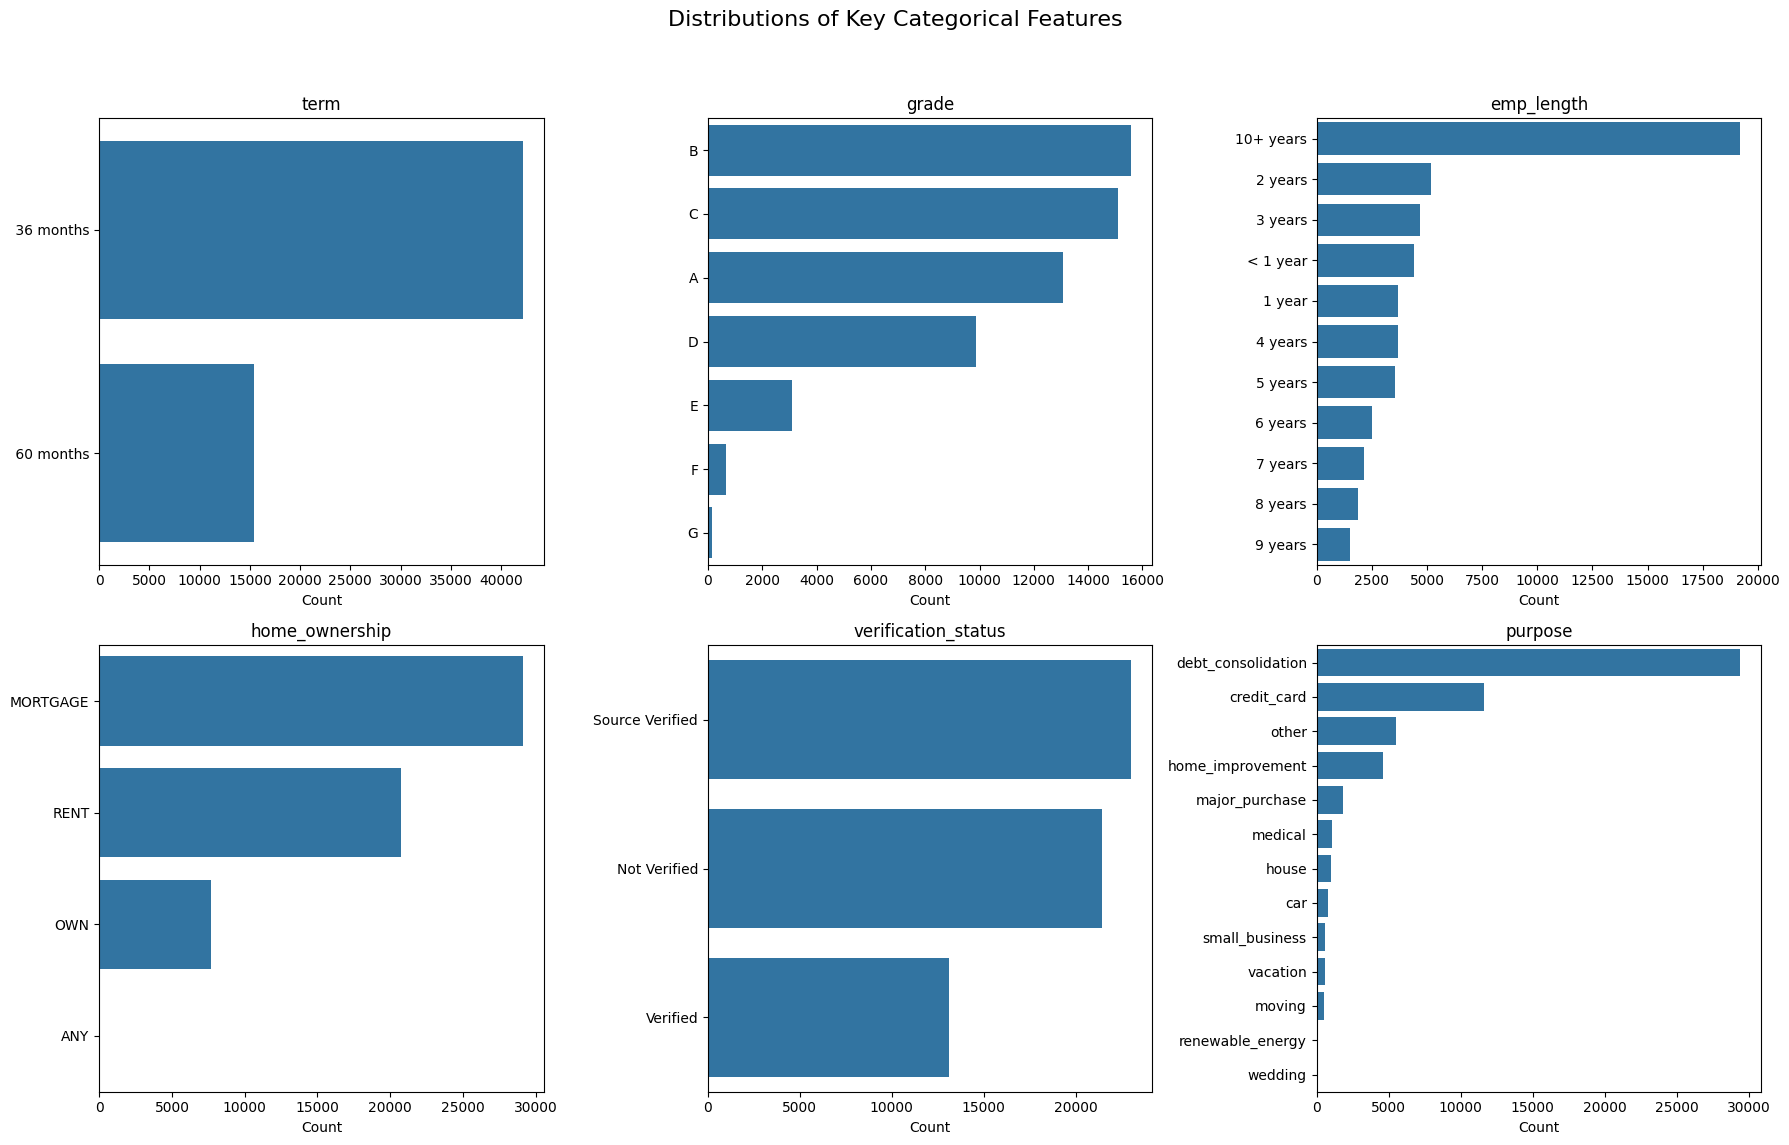

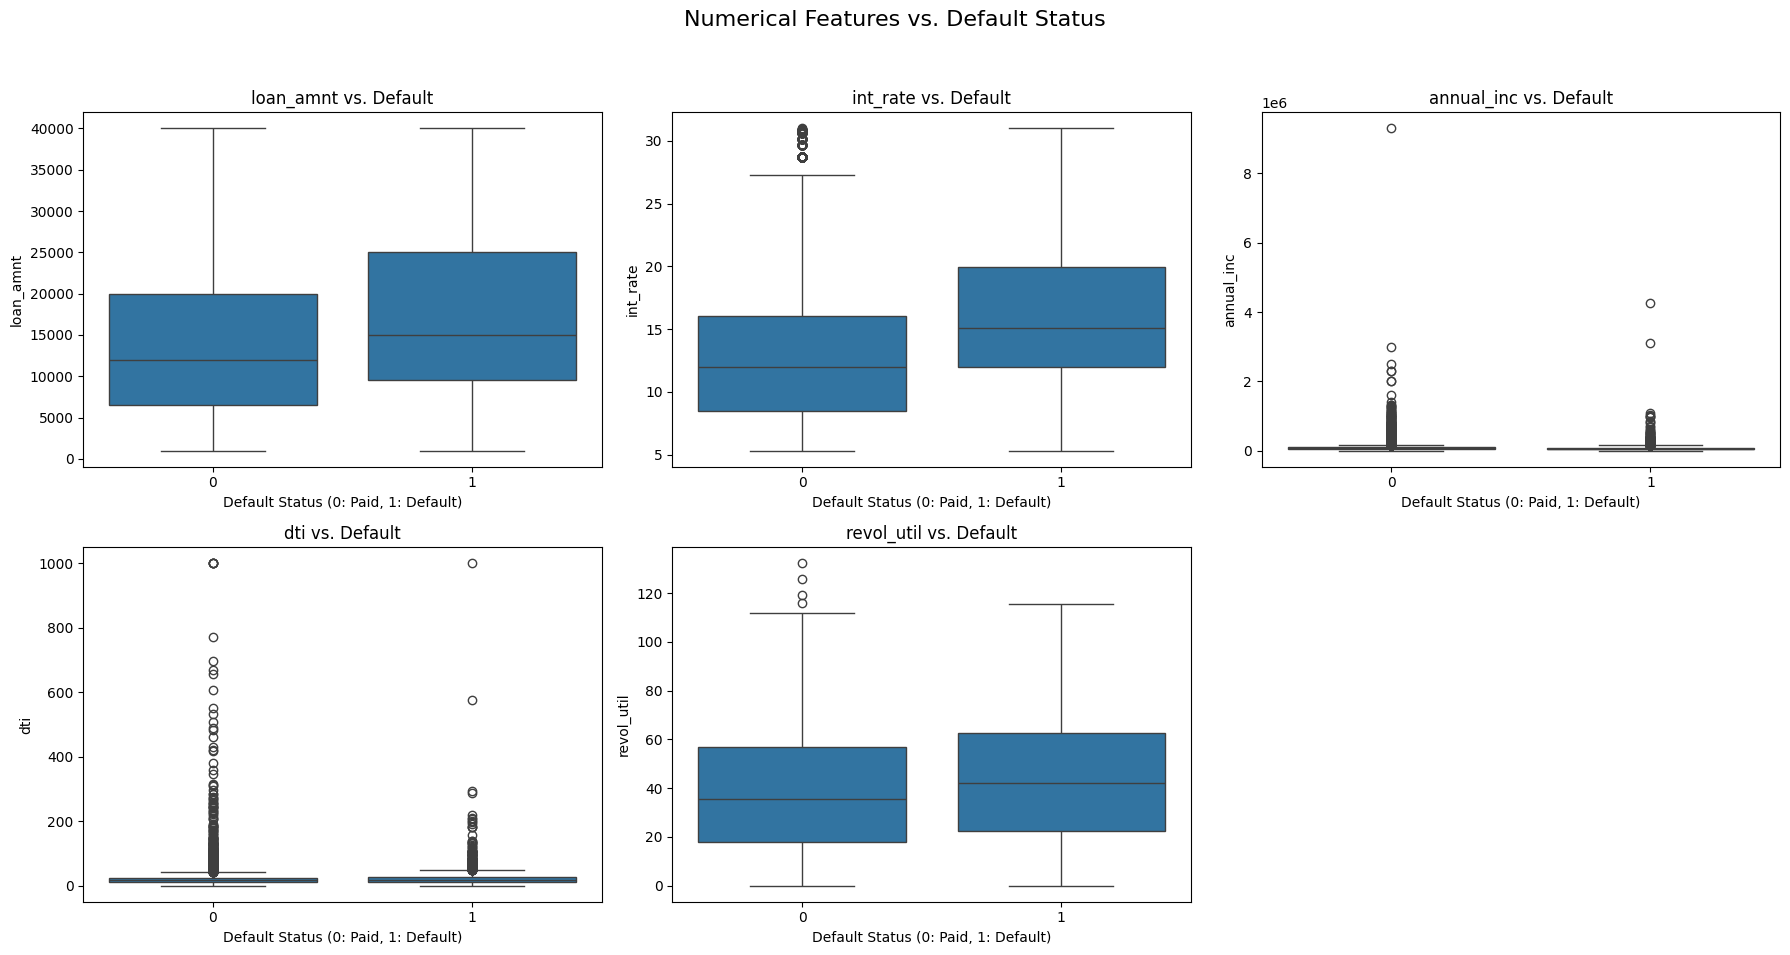

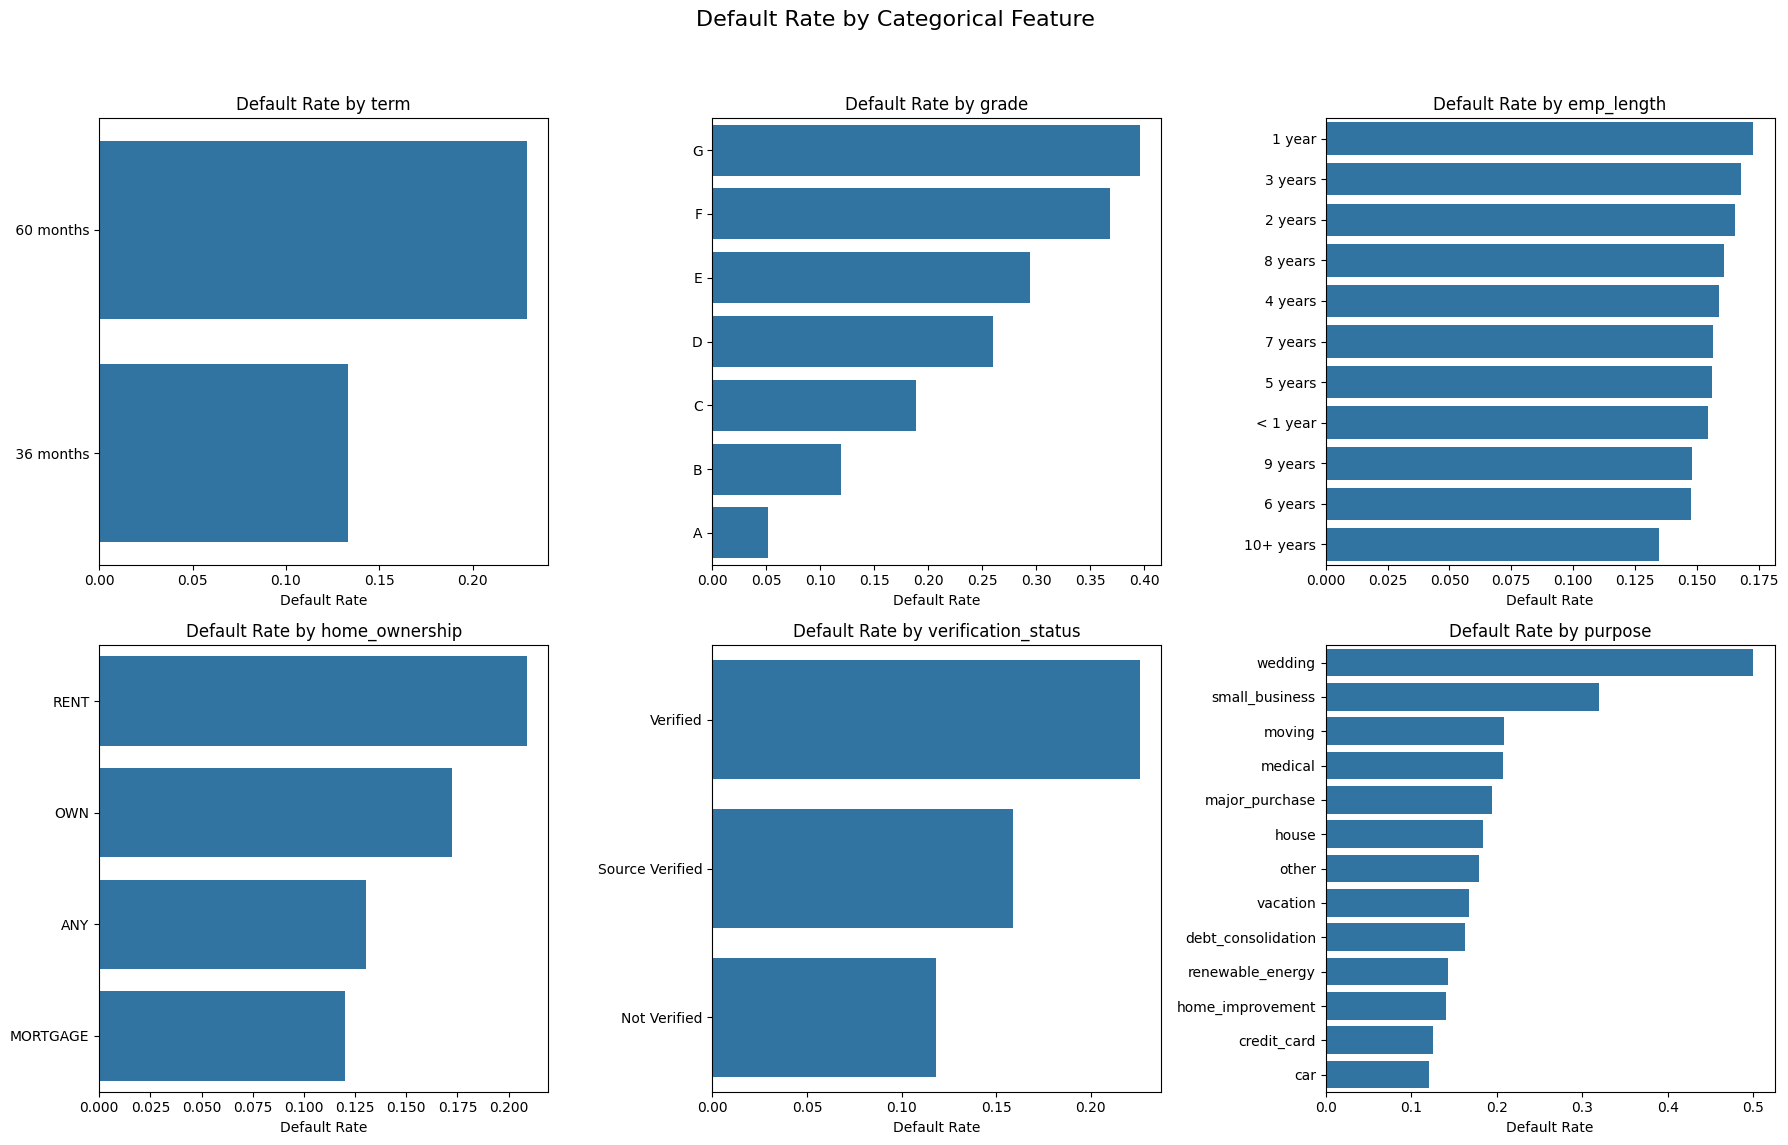


Correlation with is_default:
is_default              1.000000
int_rate                0.217063
installment             0.098981
loan_amnt               0.092726
inq_last_6mths          0.065770
revol_util              0.065234
dti                     0.029174
tax_liens               0.016077
pub_rec                 0.011191
delinq_2yrs             0.010563
pub_rec_bankruptcies    0.004125
revol_bal              -0.010054
annual_inc             -0.039381
open_acc               -0.043503
total_acc              -0.080794
mort_acc               -0.097163
Name: is_default, dtype: float64


C:\Users\amans\AppData\Local\Temp\ipykernel_492\1869028769.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')


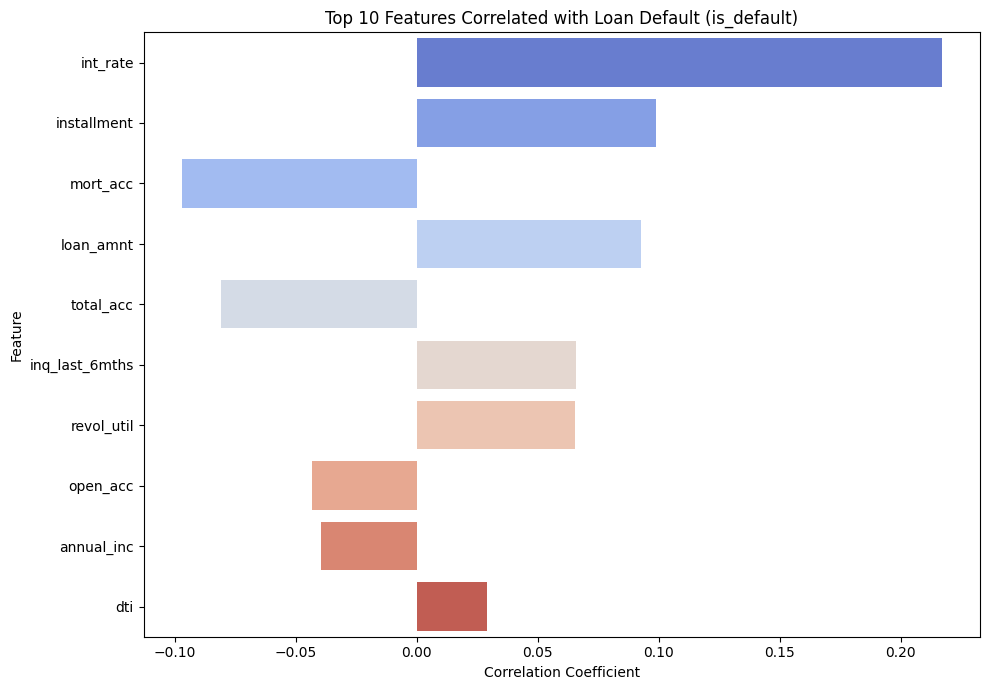

In [ ]:
print("\nStarting EDA...")
plt.figure(figsize=(6, 4))
sns.countplot(x='is_default', data=df_model)
plt.title('Distribution of Loan Default Status (0: Fully Paid, 1: Default)')
plt.savefig('eda_target_distribution.png')
plt.show()

default_rate = df_model['is_default'].mean()
print(f"Overall Default Rate: {default_rate:.2%}")

# Numerical Features Univariate
numerical_to_plot = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Distributions of Key Numerical Features', fontsize=16)
axes = axes.flatten()

for i, col in enumerate(numerical_to_plot):
    sns.histplot(df_model[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
fig.delaxes(axes[5])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('eda_numerical_univariate.png')
plt.show()

# Categorical Features Univariate
categorical_to_plot = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Distributions of Key Categorical Features', fontsize=16)
axes = axes.flatten()

for i, col in enumerate(categorical_to_plot):
    order = df_model[col].value_counts().index
    sns.countplot(y=col, data=df_model, order=order, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('eda_categorical_univariate.png')
plt.show()

# Bivariate (Numerical)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Numerical Features vs. Default Status', fontsize=16)
axes = axes.flatten()
for i, col in enumerate(numerical_to_plot):
    sns.boxplot(x='is_default', y=col, data=df_model, ax=axes[i])
    axes[i].set_title(f'{col} vs. Default')
    axes[i].set_xlabel('Default Status (0: Paid, 1: Default)')
    axes[i].set_ylabel(col)
fig.delaxes(axes[5])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('eda_numerical_bivariate.png')
plt.show()

# Bivariate (Categorical)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Default Rate by Categorical Feature', fontsize=16)
axes = axes.flatten()
for i, col in enumerate(categorical_to_plot):
    default_rates = df_model.groupby(col)['is_default'].mean().sort_values(ascending=False)
    sns.barplot(y=default_rates.index, x=default_rates.values, ax=axes[i], orient='h')
    axes[i].set_title(f'Default Rate by {col}')
    axes[i].set_xlabel('Default Rate')
    axes[i].set_ylabel('')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('eda_categorical_bivariate.png')
plt.show()

# Correlation
numerical_cols_for_corr = df_model.select_dtypes(include=np.number).columns.tolist()
correlation_matrix = df_model[numerical_cols_for_corr].corr()
corr_with_target = correlation_matrix['is_default'].sort_values(ascending=False)
print("\nCorrelation with is_default:")
print(corr_with_target)

plt.figure(figsize=(10, 7))
top_corr = corr_with_target.drop('is_default').sort_values(key=abs, ascending=False).head(10)
sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')
plt.title('Top 10 Features Correlated with Loan Default (is_default)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('eda_top_10_correlation.png')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

print("Starting feature engineering...")
df_processed = df_model.copy()

# === 1. Feature Engineering ===
# Ratios (with +1 epsilon to avoid zero division)
df_processed['income_to_loan_ratio'] = df_processed['annual_inc'] / (df_processed['loan_amnt'] + 1)
df_processed['credit_utilization_ratio'] = df_processed['revol_bal'] / (df_processed['total_acc'] + 1)

# Time-Based Features
df_processed['earliest_cr_line'] = pd.to_datetime(df_processed['earliest_cr_line'], errors='coerce')
# 'issue_d' is already datetime from the load step
df_processed['credit_history_days'] = (df_processed['issue_d'] - df_processed['earliest_cr_line']).dt.days

df_processed['term_in_months'] = df_processed['term'].str.replace(' months', '').astype(float)
df_processed['total_payment'] = df_processed['term_in_months'] * df_processed['installment']
df_processed['payment_to_income_ratio'] = df_processed['installment'] / (df_processed['annual_inc'] + 1)
df_processed['open_acc_to_total_acc'] = df_processed['open_acc'] / (df_processed['total_acc'] + 1)

# We fillna with 0 for this calculation only. Pipeline will impute originals.
df_processed['util_x_dti'] = df_processed['revol_util'].fillna(0) * df_processed['dti'].fillna(0)

# Time Features as Categorical
df_processed['issue_month'] = df_processed['issue_d'].dt.month.astype(str)
df_processed['issue_year'] = df_processed['issue_d'].dt.year.astype(str)

print("Feature Engineering complete.")

# === 2. Feature Selection ===
features_to_keep = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 
    'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 
    'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'tax_liens', 
    'income_to_loan_ratio', 'credit_utilization_ratio', 'credit_history_days', 
    'issue_month', 'issue_year', 'term_in_months', 'total_payment', 
    'payment_to_income_ratio', 'open_acc_to_total_acc', 'util_x_dti',
    # Target & Split
    'is_default', 'issue_d' 
]

# Select only the columns we need
df_processed = df_processed[features_to_keep].copy()

# Handle potential inf values from ratios
df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)

# === 3. Data Splitting (Time-Based) ===
df_processed = df_processed.sort_values(by='issue_d')
X = df_processed.drop(['is_default', 'issue_d'], axis=1)
y = df_processed['is_default']

train_size = int(0.8 * len(df_processed))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"\nData split successfully (80/20 time-based).")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# === 4. Preprocessing for LR / DT / RF (Pipeline) ===
categorical_features_ohe = [
    'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 
    'verification_status', 'purpose', 'initial_list_status', 
    'application_type', 'issue_month', 'issue_year'
]
numerical_features = [col for col in X_train.columns if col not in categorical_features_ohe]

print(f"\nIdentified {len(numerical_features)} numerical features for scaling.")
print(f"Identified {len(categorical_features_ohe)} categorical features for OHE.")

# Create the preprocessing pipelines (now with imputers)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features_ohe)
    ],
    remainder='passthrough' # This will keep 'util_x_dti' etc.
)

# Fit the preprocessor ONLY on training data
print("\nFitting preprocessor and transforming X_train (for LR/RF/DT)...")
X_train_processed = preprocessor.fit_transform(X_train)

print("Transforming X_test (for LR/RF/DT)...")
X_test_processed = preprocessor.transform(X_test)

# === 5. Preprocessing for LGBM / CatBoost (Leak-Free) ===
print("\nPreparing data for LightGBM/CatBoost (Leak-Free)...")
X_train_gb = X_train.copy()
X_test_gb = X_test.copy()
y_train_gb = y_train.copy()
y_test_gb = y_test.copy()  
# ----------------------

# Define categorical features for boosting models
categorical_features_for_boost = [
    'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 
    'verification_status', 'purpose', 'initial_list_status', 
    'application_type', 'issue_month', 'issue_year'
]

# Create and fit imputers/encoders ONLY on training data
imputation_values = {}
label_encoders = {}

for col in X_train_gb.columns:
    if col in categorical_features_for_boost:
        # Categorical: Impute with mode and LabelEncode
        mode_val = X_train_gb[col].mode()[0]
        imputation_values[col] = mode_val
        X_train_gb[col] = X_train_gb[col].fillna(mode_val).astype(str)
        X_test_gb[col] = X_test_gb[col].fillna(mode_val).astype(str)
        
        le = LabelEncoder()
        le.fit(X_train_gb[col]) 
        X_train_gb[col] = le.transform(X_train_gb[col])
        
        # Handle new categories in test set by mapping to a new class (-1)
        X_test_gb[col] = X_test_gb[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
        label_encoders[col] = le
        
    elif col in numerical_features:
        # Numerical: Impute with median
        median_val = X_train_gb[col].median()
        imputation_values[col] = median_val
        X_train_gb[col] = X_train_gb[col].fillna(median_val)
        X_test_gb[col] = X_test_gb[col].fillna(median_val)

# Convert all categorical columns to 'category' dtype for LightGBM
for col in categorical_features_for_boost:
    X_train_gb[col] = X_train_gb[col].astype('category')
    X_test_gb[col] = X_test_gb[col].astype('category')
        
print("X_train_gb and X_test_gb prepared for LightGBM/CatBoost.")
print(f"Categorical features for boost: {categorical_features_for_boost}")

Starting feature engineering...
Feature Engineering complete.

Data split successfully (80/20 time-based).
X_train shape: (46030, 34), X_test shape: (11508, 34)

Identified 23 numerical features for scaling.
Identified 11 categorical features for OHE.

Fitting preprocessor and transforming X_train (for LR/RF/DT)...


C:\Users\amans\AppData\Local\Temp\ipykernel_492\704984184.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_processed['earliest_cr_line'] = pd.to_datetime(df_processed['earliest_cr_line'], errors='coerce')


Transforming X_test (for LR/RF/DT)...

Preparing data for LightGBM/CatBoost (Leak-Free)...
X_train_gb and X_test_gb prepared for LightGBM/CatBoost.
Categorical features for boost: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type', 'issue_month', 'issue_year']


In [5]:
# --- 6. Model Training ---

# Evaluation Function (defined here to be used by all models)
def evaluate_model(model, X_test_data, y_test_data, model_name):
    print(f"\n--- Evaluation Report for: {model_name} ---")
    
    # Handle sparse matrix from LR/RF pipeline
    if not isinstance(X_test_data, pd.DataFrame):
        y_pred = model.predict(X_test_data)
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]
    else:
        y_pred = model.predict(X_test_data)
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]
        
    test_auc = roc_auc_score(y_test_data, y_pred_proba)
    print(f"Test Set ROC AUC Score: {test_auc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test_data, y_pred, target_names=['Fully Paid (0)', 'Default (1)']))
    
    print("Confusion Matrix & ROC Curve:")
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test_data, y_test_data, 
                                          cmap='Blues', 
                                          display_labels=['Fully Paid', 'Default'],
                                          ax=ax[0])
    ax[0].set_title(f"{model_name} - Confusion Matrix")
    RocCurveDisplay.from_estimator(model, X_test_data, y_test_data, ax=ax[1])
    ax[1].plot([0, 1], [0, 1], color='red', linestyle='--')
    ax[1].set_title(f"{model_name} - ROC Curve")
    plt.tight_layout()
    plt.savefig(f'evaluation_{model_name.replace(" ", "_")}.png')
    plt.show()


In [9]:
# --- Model 1: Logistic Regression ---
model_lr = LogisticRegression(
    penalty='l2', solver='lbfgs', class_weight='balanced', 
    random_state=42, max_iter=1000
)
param_dist_lr = {'C': loguniform(0.001, 100)}
random_search_lr = RandomizedSearchCV(
    model_lr, param_dist_lr, n_iter=10, cv=5, 
    scoring='roc_auc', n_jobs=2, random_state=42
)
print("\nStarting RandomizedSearchCV for Logistic Regression...")
random_search_lr.fit(X_train_processed, y_train)
print("Search complete.")
print("Best LR hyperparameters:", random_search_lr.best_params_)
print("Best LR cross-val ROC AUC:", random_search_lr.best_score_)
best_lr_model = random_search_lr.best_estimator_



Starting RandomizedSearchCV for Logistic Regression...
Search complete.
Best LR hyperparameters: {'C': np.float64(0.0019517224641449498)}
Best LR cross-val ROC AUC: 0.6821310782443123


In [10]:
# --- Model 2: Decision Tree ---
model_dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
param_dist_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy']
}
random_search_dt = RandomizedSearchCV(
    model_dt, param_dist_dt, n_iter=10, cv=5, 
    scoring='roc_auc', n_jobs=2, random_state=42
)
print("\nStarting RandomizedSearchCV for Decision Tree...")
random_search_dt.fit(X_train_processed, y_train) 
print("Search complete.")
print("Best DT hyperparameters:", random_search_dt.best_params_)
print("Best DT cross-val ROC AUC:", random_search_dt.best_score_)
best_dt_model = random_search_dt.best_estimator_



Starting RandomizedSearchCV for Decision Tree...
Search complete.
Best DT hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 12}
Best DT cross-val ROC AUC: 0.6244203573352675


In [19]:
# --- Model 3: Random Forest ---
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}
random_search_rf = RandomizedSearchCV(
    model_rf, param_dist_rf, n_iter=10, cv=3, 
    scoring='roc_auc', n_jobs=2, verbose=1, random_state=42
)
print("\nStarting RandomizedSearchCV for Random Forest...")
random_search_rf.fit(X_train_processed, y_train) 
print("\nSearch complete.")
print("Best RF hyperparameters:", random_search_rf.best_params_)
print("Best RF cross-val ROC AUC:", random_search_rf.best_score_)
best_rf_model = random_search_rf.best_estimator_



Starting RandomizedSearchCV for Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Search complete.
Best RF hyperparameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 16, 'min_samples_split': 16, 'n_estimators': 289}
Best RF cross-val ROC AUC: 0.7084918869662892


In [14]:
# --- Model 4: LightGBM (Optuna Tuning) ---
print("\n\n--- OPTUNA HYPERPARAMETER TUNING FOR LIGHTGBM ---")

# Calculate scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Using scale_pos_weight for LGBM: {scale_pos_weight:.2f}")

# Define Monotonic Constraints
constraints = {
    'dti': 1, 'int_rate': 1, 'util_x_dti': 1,
    'annual_inc': -1, 'income_to_loan_ratio': -1, 
    'credit_history_days': -1
}
mc_list = [constraints.get(col, 0) for col in X_train_gb.columns]

def objective(trial):
    # Define the search space
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'n_jobs': -1,
        'monotone_constraints': mc_list
    }
    
    model = lgb.LGBMClassifier(**params)
    
    model.fit(
        X_train_gb, 
        y_train,
        eval_set=[(X_test_gb, y_test)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(100, verbose=False)],
        categorical_feature=categorical_features_for_boost
    )
    
    preds = model.predict_proba(X_test_gb)[:, 1]
    auc = roc_auc_score(y_test, preds)
    return auc

# Run the optimization
print("Starting Optuna study...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) # Increase n_trials for better results

print("\nOptuna search complete.")
print("Best trial:")
print(f"  Value (AUC): {study.best_value:.4f}")
print("  Params: ")
print(study.best_params)

# Store best params
best_lgbm_params = study.best_params

[I 2025-11-07 21:02:59,193] A new study created in memory with name: no-name-9d3ed738-3659-4e56-ac48-3378490ebb58




--- OPTUNA HYPERPARAMETER TUNING FOR LIGHTGBM ---
Using scale_pos_weight for LGBM: 4.43
Starting Optuna study...
[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:04,134] Trial 0 finished with value: 0.7031408124709989 and parameters: {'learning_rate': 0.012606274091076397, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 88, 'subsample': 0.664148888073268, 'colsample_bytree': 0.801962932341697, 'reg_alpha': 0.09137651593448215, 'reg_lambda': 0.16369105234893422}. Best is trial 0 with value: 0.7031408124709989.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-11-07 21:03:08,660] Trial 1 finished with value: 0.7013524150960072 and parameters: {'learning_rate': 0.03007797444097678, 'num_leaves': 28, 'max_depth': 5, 'min_child_samples': 56, 'subsample': 0.7234444423641503, 'colsample_bytree': 0.9107616435170343, 'reg_alpha': 0.5123267329254209, 'reg_lambda': 0.6951498910790604}. Best is trial 0 with value: 0.7031408124709989.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-11-07 21:03:11,457] Trial 2 finished with value: 0.7018856199041033 and parameters: {'learning_rate': 0.06381999987947522, 'num_leaves': 40, 'max_depth': 5, 'min_child_samples': 58, 'subsample': 0.7238212895724504, 'colsample_bytree': 0.7759693490211286, 'reg_alpha': 0.3474911871472929, 'reg_lambda': 0.49972073132742}. Best is trial 0 with value: 0.7031408124709989.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]

[I 2025-11-07 21:03:13,063] Trial 3 finished with value: 0.7018653191771438 and parameters: {'learning_rate': 0.06303082026462088, 'num_leaves': 25, 'max_depth': 7, 'min_child_samples': 71, 'subsample': 0.6756471948940006, 'colsample_bytree': 0.9719116639885444, 'reg_alpha': 0.9916935953355589, 'reg_lambda': 0.6047712748411596}. Best is trial 0 with value: 0.7031408124709989.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:16,936] Trial 4 finished with value: 0.7024054289944097 and parameters: {'learning_rate': 0.011821372024348431, 'num_leaves': 38, 'max_depth': 15, 'min_child_samples': 85, 'subsample': 0.7484636192108758, 'colsample_bytree': 0.9812637505810052, 'reg_alpha': 0.6097034740812018, 'reg_lambda': 0.40502927637999264}. Best is trial 0 with value: 0.7031408124709989.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:20,879] Trial 5 finished with value: 0.7028970656473033 and parameters: {'learning_rate': 0.012415425617657624, 'num_leaves': 22, 'max_depth': 15, 'min_child_samples': 78, 'subsample': 0.7737962655347126, 'colsample_bytree': 0.910624936699301, 'reg_alpha': 0.26500721953868756, 'reg_lambda': 0.6425889999934571}. Best is trial 0 with value: 0.7031408124709989.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:23,241] Trial 6 finished with value: 0.7019822900324811 and parameters: {'learning_rate': 0.021624437226958188, 'num_leaves': 36, 'max_depth': 15, 'min_child_samples': 83, 'subsample': 0.7198524316855551, 'colsample_bytree': 0.9764223860366134, 'reg_alpha': 0.013136078466351564, 'reg_lambda': 0.8353469712776684}. Best is trial 0 with value: 0.7031408124709989.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:26,127] Trial 7 finished with value: 0.7029002419515213 and parameters: {'learning_rate': 0.016169791781886104, 'num_leaves': 36, 'max_depth': 15, 'min_child_samples': 46, 'subsample': 0.6437452321563051, 'colsample_bytree': 0.9621048952570097, 'reg_alpha': 0.7625528429724641, 'reg_lambda': 0.4606089824629528}. Best is trial 0 with value: 0.7031408124709989.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:29,755] Trial 8 finished with value: 0.7019959619506375 and parameters: {'learning_rate': 0.011157864278842161, 'num_leaves': 60, 'max_depth': 9, 'min_child_samples': 36, 'subsample': 0.9048253083385053, 'colsample_bytree': 0.9814738636118397, 'reg_alpha': 0.3548097430205772, 'reg_lambda': 0.2710803904937682}. Best is trial 0 with value: 0.7031408124709989.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-07 21:03:31,081] Trial 9 finished with value: 0.701925047506463 and parameters: {'learning_rate': 0.05369956432535358, 'num_leaves': 31, 'max_depth': 7, 'min_child_samples': 63, 'subsample': 0.6795849018166491, 'colsample_bytree': 0.603896509369624, 'reg_alpha': 0.7996202254035557, 'reg_lambda': 0.8244256077854739}. Best is trial 0 with value: 0.7031408124709989.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:32,760] Trial 10 finished with value: 0.7008084384736063 and parameters: {'learning_rate': 0.034821837325367595, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 98, 'subsample': 0.8676125210738936, 'colsample_bytree': 0.7475658572330839, 'reg_alpha': 0.033358293022060004, 'reg_lambda': 0.04217345798133797}. Best is trial 0 with value: 0.7031408124709989.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:35,598] Trial 11 finished with value: 0.7023278166913406 and parameters: {'learning_rate': 0.017415722955447622, 'num_leaves': 49, 'max_depth': 12, 'min_child_samples': 36, 'subsample': 0.6334238544017919, 'colsample_bytree': 0.6838563479009709, 'reg_alpha': 0.6966904402228219, 'reg_lambda': 0.13807933283486748}. Best is trial 0 with value: 0.7031408124709989.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:38,087] Trial 12 finished with value: 0.7031508937843869 and parameters: {'learning_rate': 0.021431984496026384, 'num_leaves': 49, 'max_depth': 12, 'min_child_samples': 46, 'subsample': 0.6043146282770767, 'colsample_bytree': 0.8554971693755532, 'reg_alpha': 0.8785351200497746, 'reg_lambda': 0.2924424551926371}. Best is trial 12 with value: 0.7031508937843869.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:41,115] Trial 13 finished with value: 0.7019220783525201 and parameters: {'learning_rate': 0.023307816339810394, 'num_leaves': 50, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.6175842795116778, 'colsample_bytree': 0.8399095814389824, 'reg_alpha': 0.9779094269332496, 'reg_lambda': 0.2565306145711518}. Best is trial 12 with value: 0.7031508937843869.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-11-07 21:03:42,578] Trial 14 finished with value: 0.7015554914156926 and parameters: {'learning_rate': 0.09831971236204044, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 91, 'subsample': 0.9847087911139427, 'colsample_bytree': 0.8134305314456242, 'reg_alpha': 0.17367070245172267, 'reg_lambda': 0.2675246323862787}. Best is trial 12 with value: 0.7031508937843869.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:47,715] Trial 15 finished with value: 0.7020328346996045 and parameters: {'learning_rate': 0.016400469039280594, 'num_leaves': 54, 'max_depth': 13, 'min_child_samples': 45, 'subsample': 0.6008411427705533, 'colsample_bytree': 0.8521340864538769, 'reg_alpha': 0.47396874392717836, 'reg_lambda': 0.0009186756621850922}. Best is trial 12 with value: 0.7031508937843869.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:49,776] Trial 16 finished with value: 0.7038436043043065 and parameters: {'learning_rate': 0.02832330324762851, 'num_leaves': 44, 'max_depth': 13, 'min_child_samples': 70, 'subsample': 0.8223612031222314, 'colsample_bytree': 0.7172366514190939, 'reg_alpha': 0.8338284404988003, 'reg_lambda': 0.1673235845203594}. Best is trial 16 with value: 0.7038436043043065.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-07 21:03:51,867] Trial 17 finished with value: 0.7026602238327773 and parameters: {'learning_rate': 0.038898235626293125, 'num_leaves': 46, 'max_depth': 10, 'min_child_samples': 69, 'subsample': 0.8450453721161083, 'colsample_bytree': 0.7072246344810101, 'reg_alpha': 0.8752719311299381, 'reg_lambda': 0.9890528018807394}. Best is trial 16 with value: 0.7038436043043065.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:54,471] Trial 18 finished with value: 0.7030227368141945 and parameters: {'learning_rate': 0.027815388605101743, 'num_leaves': 44, 'max_depth': 13, 'min_child_samples': 48, 'subsample': 0.8074657740426182, 'colsample_bytree': 0.6397553731042717, 'reg_alpha': 0.8554644688341536, 'reg_lambda': 0.35178039900412356}. Best is trial 16 with value: 0.7038436043043065.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:03:56,439] Trial 19 finished with value: 0.7013522769958238 and parameters: {'learning_rate': 0.04334069973969515, 'num_leaves': 44, 'max_depth': 13, 'min_child_samples': 31, 'subsample': 0.9402041451185, 'colsample_bytree': 0.7414283454995303, 'reg_alpha': 0.6324538208380599, 'reg_lambda': 0.15074138741088755}. Best is trial 16 with value: 0.7038436043043065.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-07 21:04:00,250] Trial 20 finished with value: 0.7029361479992046 and parameters: {'learning_rate': 0.02245394579425585, 'num_leaves': 54, 'max_depth': 11, 'min_child_samples': 71, 'subsample': 0.8183963221234161, 'colsample_bytree': 0.8560776536481534, 'reg_alpha': 0.9224486336735336, 'reg_lambda': 0.32787777898851417}. Best is trial 16 with value: 0.7038436043043065.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:04:04,042] Trial 21 finished with value: 0.702592692843096 and parameters: {'learning_rate': 0.01417133936998822, 'num_leaves': 55, 'max_depth': 14, 'min_child_samples': 94, 'subsample': 0.6738819202595288, 'colsample_bytree': 0.7863592109083841, 'reg_alpha': 0.1533101730371208, 'reg_lambda': 0.1472390864063366}. Best is trial 16 with value: 0.7038436043043065.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-11-07 21:04:08,591] Trial 22 finished with value: 0.7015892569105332 and parameters: {'learning_rate': 0.019872569630042358, 'num_leaves': 57, 'max_depth': 11, 'min_child_samples': 80, 'subsample': 0.772805454663222, 'colsample_bytree': 0.8877126818350989, 'reg_alpha': 0.7168831337189551, 'reg_lambda': 0.1881227734543558}. Best is trial 16 with value: 0.7038436043043065.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:04:11,472] Trial 23 finished with value: 0.7049020041098614 and parameters: {'learning_rate': 0.026811620296593223, 'num_leaves': 45, 'max_depth': 11, 'min_child_samples': 53, 'subsample': 0.6531666783374291, 'colsample_bytree': 0.7023746298174357, 'reg_alpha': 0.5022157814886137, 'reg_lambda': 0.06908953724434923}. Best is trial 23 with value: 0.7049020041098614.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:04:13,871] Trial 24 finished with value: 0.7034802627217889 and parameters: {'learning_rate': 0.025638965406433397, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 51, 'subsample': 0.8731303847769888, 'colsample_bytree': 0.6579312574909407, 'reg_alpha': 0.5133667471368752, 'reg_lambda': 0.07232895409901552}. Best is trial 23 with value: 0.7049020041098614.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-11-07 21:04:16,383] Trial 25 finished with value: 0.7046231798395828 and parameters: {'learning_rate': 0.02797070873441514, 'num_leaves': 42, 'max_depth': 8, 'min_child_samples': 52, 'subsample': 0.8999057793852632, 'colsample_bytree': 0.6679520736228781, 'reg_alpha': 0.5129497379116883, 'reg_lambda': 0.0668455167685926}. Best is trial 23 with value: 0.7049020041098614.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-11-07 21:04:19,146] Trial 26 finished with value: 0.702669200344698 and parameters: {'learning_rate': 0.0330853058322016, 'num_leaves': 42, 'max_depth': 8, 'min_child_samples': 64, 'subsample': 0.9188620246296554, 'colsample_bytree': 0.7145372159878879, 'reg_alpha': 0.43837363635575044, 'reg_lambda': 0.06840137338420338}. Best is trial 23 with value: 0.7049020041098614.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-11-07 21:04:20,908] Trial 27 finished with value: 0.7027515080540028 and parameters: {'learning_rate': 0.045121921683394246, 'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 55, 'subsample': 0.9933585753261797, 'colsample_bytree': 0.651292130763311, 'reg_alpha': 0.5941167531259554, 'reg_lambda': 0.07732058910178286}. Best is trial 23 with value: 0.7049020041098614.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674
[LightGBM] [Warning] No further splits with positive gain

[I 2025-11-07 21:04:23,421] Trial 28 finished with value: 0.7040025576153965 and parameters: {'learning_rate': 0.02728390700160352, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 40, 'subsample': 0.8443456017485163, 'colsample_bytree': 0.6187959758901855, 'reg_alpha': 0.37084666966701396, 'reg_lambda': 0.2151401686223328}. Best is trial 23 with value: 0.7049020041098614.


[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674


[I 2025-11-07 21:04:25,297] Trial 29 finished with value: 0.703297694279338 and parameters: {'learning_rate': 0.03696171375305135, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 31, 'subsample': 0.9572481779588804, 'colsample_bytree': 0.6014510199864034, 'reg_alpha': 0.37903125107826785, 'reg_lambda': 0.21409331839937285}. Best is trial 23 with value: 0.7049020041098614.



Optuna search complete.
Best trial:
  Value (AUC): 0.7049
  Params: 
{'learning_rate': 0.026811620296593223, 'num_leaves': 45, 'max_depth': 11, 'min_child_samples': 53, 'subsample': 0.6531666783374291, 'colsample_bytree': 0.7023746298174357, 'reg_alpha': 0.5022157814886137, 'reg_lambda': 0.06908953724434923}


In [ ]:
# --- Model 4: LightGBM (Final Fit) ---
print("\nStarting LightGBM final training with best params...")

# Add n_estimators and other fixed params
final_lgbm_params = best_lgbm_params.copy()
final_lgbm_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'n_estimators': 2000, # Higher for final fit
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'monotone_constraints': mc_list
})

lgbm = lgb.LGBMClassifier(**final_lgbm_params) 

lgbm.fit(
    X_train_gb, 
    y_train,
    eval_set=[(X_test_gb, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(100, verbose=100)],
    categorical_feature=categorical_features_for_boost
)

print("LightGBM final training complete.")


Starting LightGBM final training with best params...
[LightGBM] [Info] Number of positive: 8482, number of negative: 37548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 46030, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184271 -> initscore=-1.487674
[LightGBM] [Info] Start training from score -1.487674
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[139]	valid_0's auc: 0.704902
LightGBM final training complete.


In [ ]:
# --- Model 5: CatBoost (Advanced) ---
cat_model = cb.CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.02, 
    auto_class_weights='Balanced',
    eval_metric='AUC', 
    random_seed=42, 
    early_stopping_rounds=100, 
    verbose=100
)

print("\nStarting CatBoost training...")
cat_model.fit(
    X_train_gb, 
    y_train_gb.values,
    eval_set=(X_test_gb, y_test_gb.values),
    cat_features=categorical_features_for_boost
)
print("CatBoost training complete.")


Starting CatBoost training...
0:	test: 0.6843999	best: 0.6843999 (0)	total: 221ms	remaining: 3m 40s
100:	test: 0.6986694	best: 0.6989373 (98)	total: 6.98s	remaining: 1m 2s
200:	test: 0.7014944	best: 0.7020067 (185)	total: 15.1s	remaining: 1m
300:	test: 0.7045877	best: 0.7048310 (277)	total: 22.5s	remaining: 52.2s
400:	test: 0.7042808	best: 0.7054863 (331)	total: 28.4s	remaining: 42.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.705486306
bestIteration = 331

Shrink model to first 332 iterations.
CatBoost training complete.




--- COMPREHENSIVE MODEL EVALUATION ---

--- Evaluation Report for: Logistic Regression ---
Test Set ROC AUC Score: 0.6951

Classification Report:
                precision    recall  f1-score   support

Fully Paid (0)       0.97      0.64      0.77     10840
   Default (1)       0.10      0.65      0.17       668

      accuracy                           0.64     11508
     macro avg       0.53      0.64      0.47     11508
  weighted avg       0.92      0.64      0.73     11508

Confusion Matrix & ROC Curve:


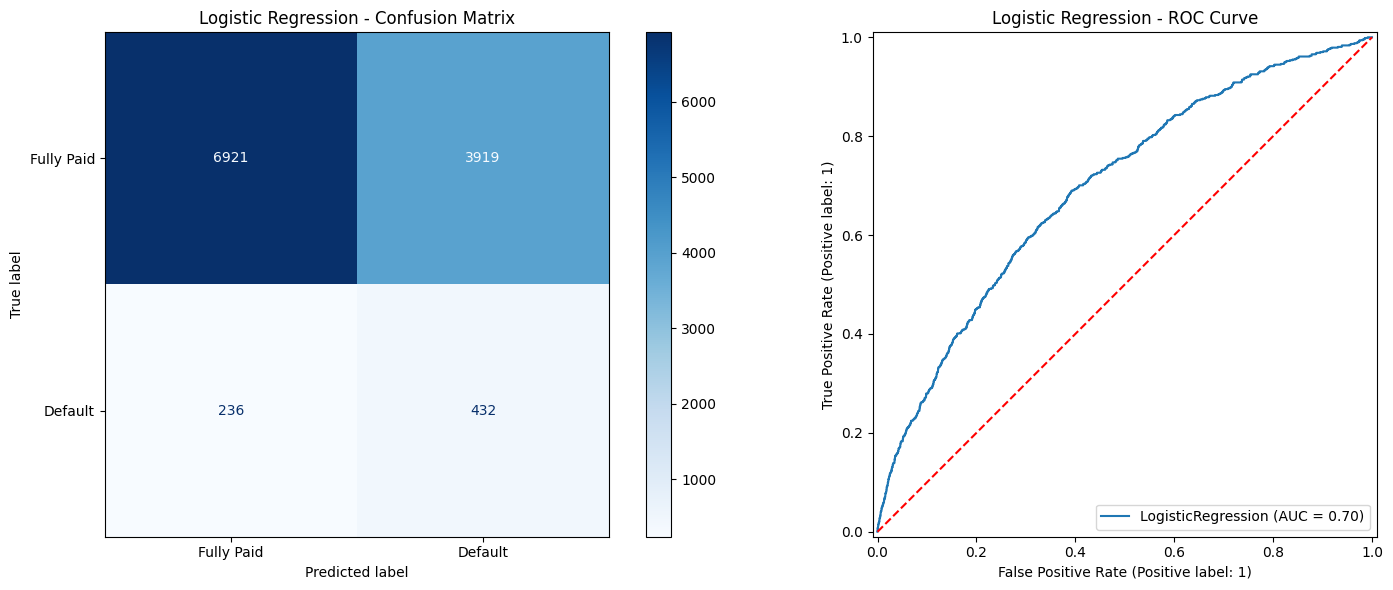


--- Evaluation Report for: Decision Tree ---
Test Set ROC AUC Score: 0.6809

Classification Report:
                precision    recall  f1-score   support

Fully Paid (0)       0.97      0.64      0.77     10840
   Default (1)       0.10      0.65      0.17       668

      accuracy                           0.64     11508
     macro avg       0.53      0.65      0.47     11508
  weighted avg       0.92      0.64      0.74     11508

Confusion Matrix & ROC Curve:


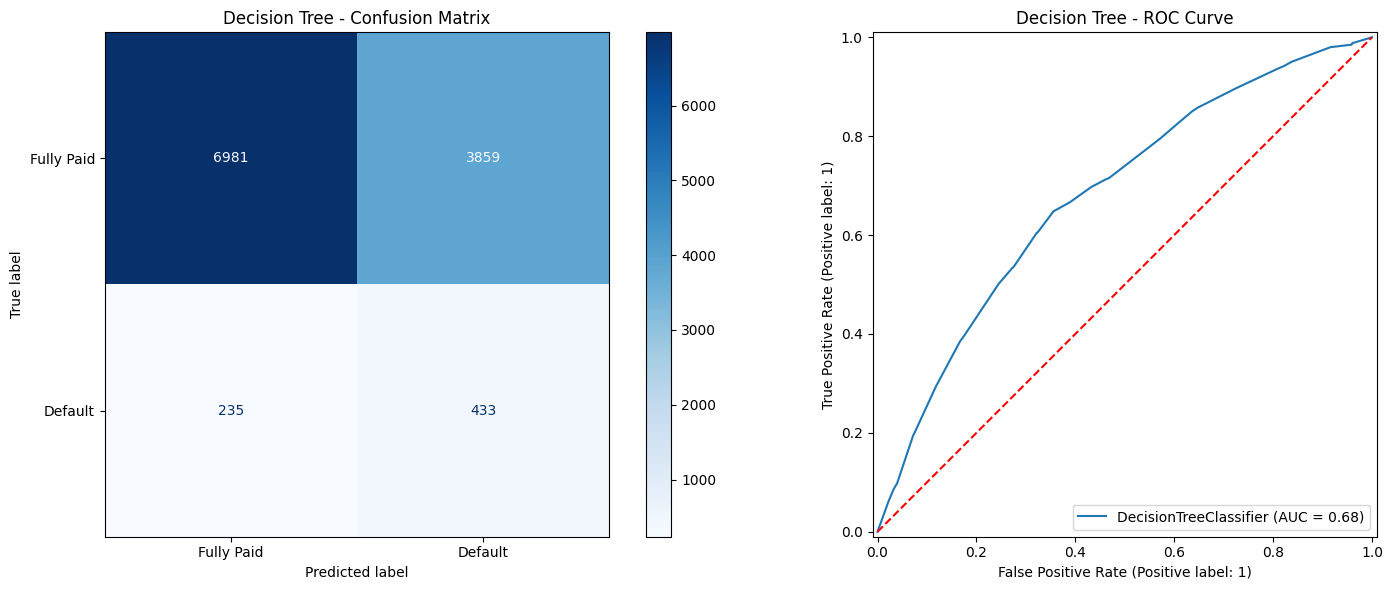


--- Evaluation Report for: Random Forest ---
Test Set ROC AUC Score: 0.7078

Classification Report:
                precision    recall  f1-score   support

Fully Paid (0)       0.96      0.73      0.83     10840
   Default (1)       0.11      0.57      0.19       668

      accuracy                           0.72     11508
     macro avg       0.54      0.65      0.51     11508
  weighted avg       0.92      0.72      0.79     11508

Confusion Matrix & ROC Curve:


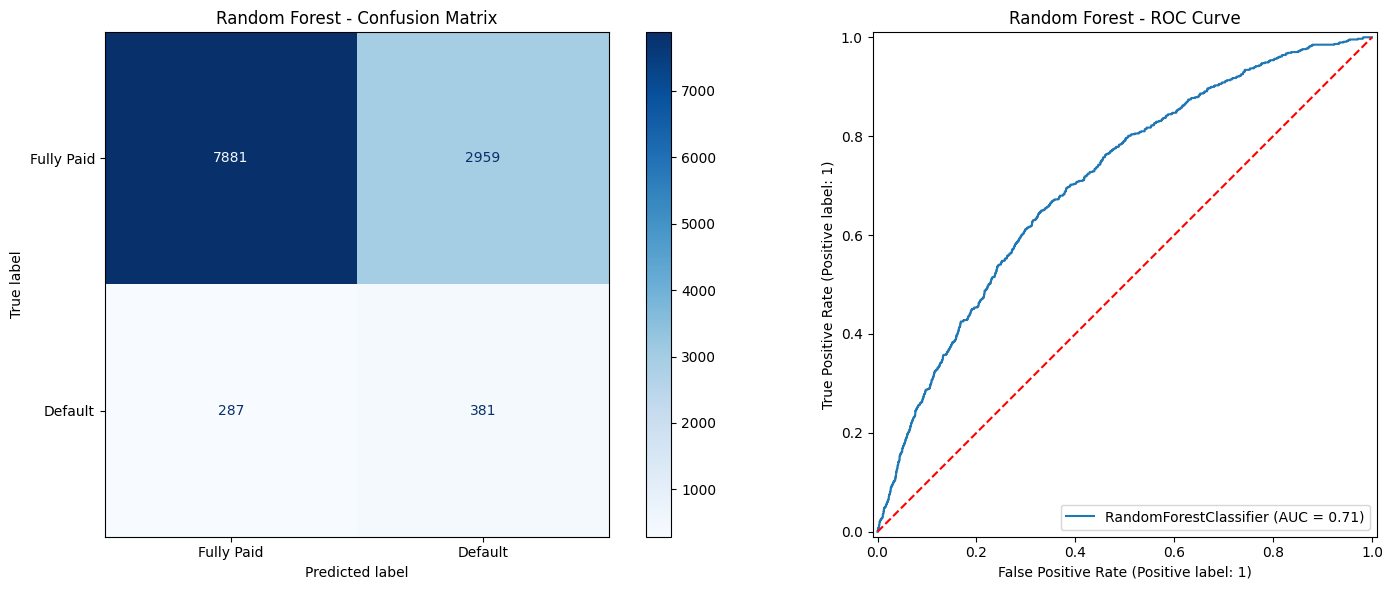


--- Evaluation Report for: LightGBM (Tuned) ---
Test Set ROC AUC Score: 0.7049

Classification Report:
                precision    recall  f1-score   support

Fully Paid (0)       0.97      0.65      0.78     10840
   Default (1)       0.10      0.64      0.18       668

      accuracy                           0.65     11508
     macro avg       0.53      0.65      0.48     11508
  weighted avg       0.92      0.65      0.74     11508

Confusion Matrix & ROC Curve:


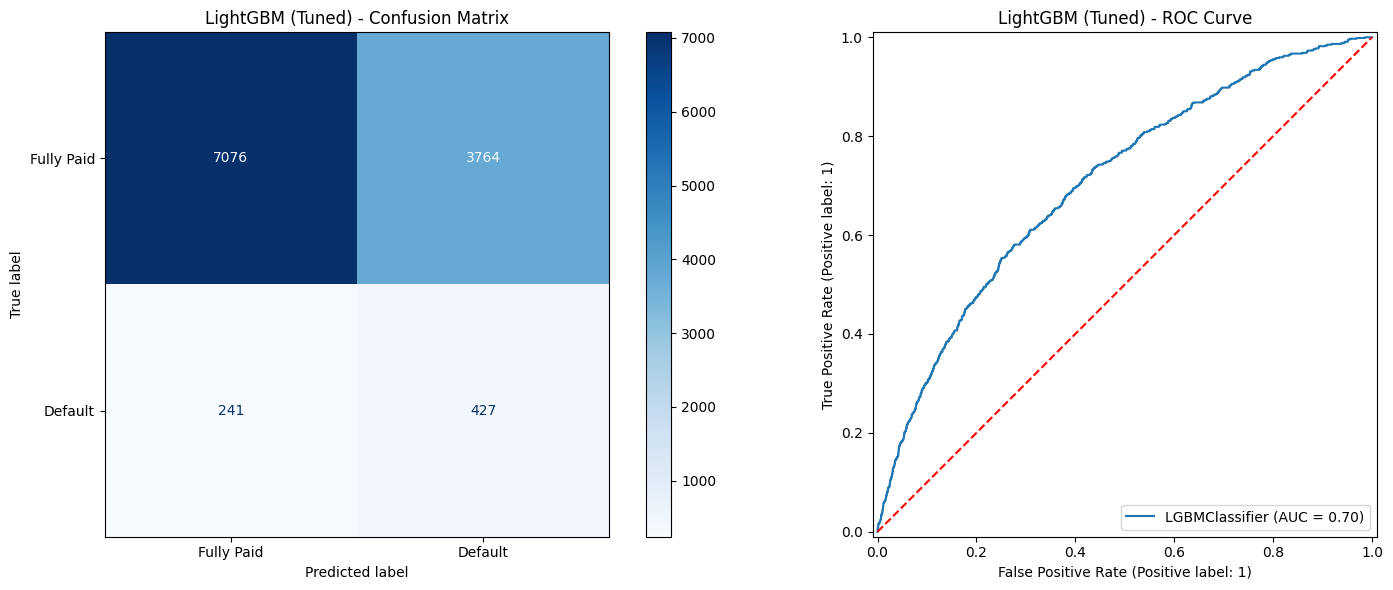


--- Evaluation Report for: CatBoost ---
Test Set ROC AUC Score: 0.7055

Classification Report:
                precision    recall  f1-score   support

Fully Paid (0)       0.97      0.69      0.81     10840
   Default (1)       0.11      0.60      0.18       668

      accuracy                           0.69     11508
     macro avg       0.54      0.65      0.50     11508
  weighted avg       0.92      0.69      0.77     11508

Confusion Matrix & ROC Curve:


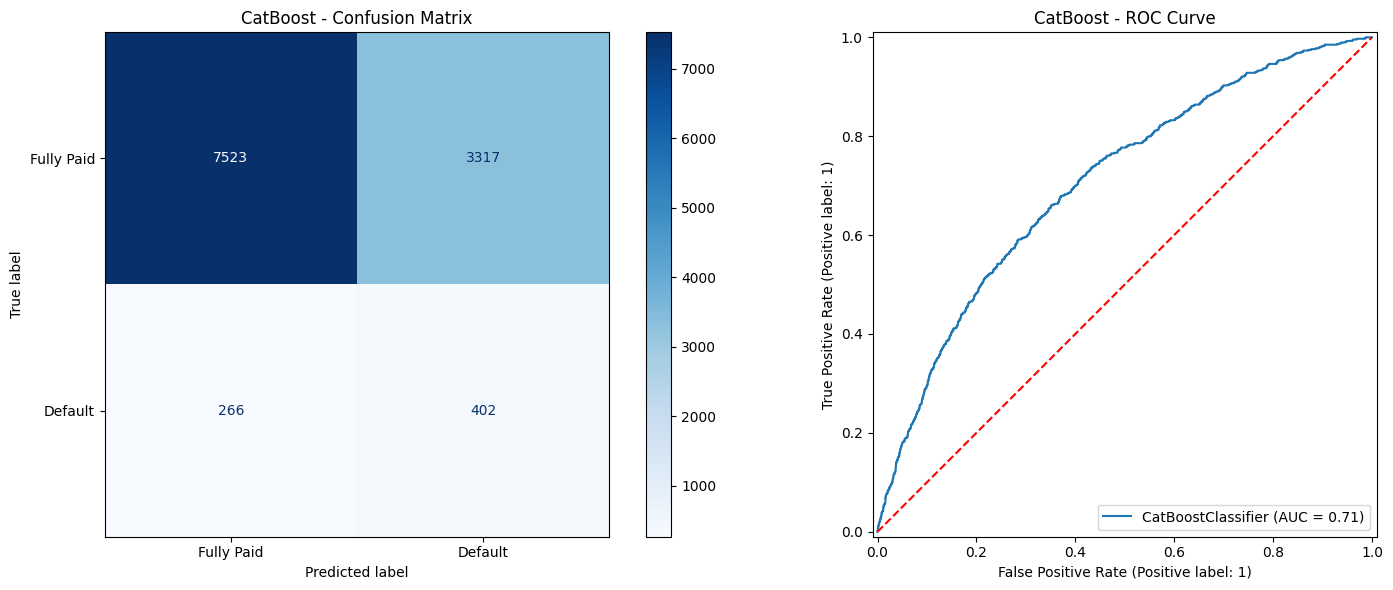

In [22]:
# --- 7. Model Evaluation (All Models) ---
print("\n\n--- COMPREHENSIVE MODEL EVALUATION ---")
evaluate_model(best_lr_model, X_test_processed, y_test, "Logistic Regression")
evaluate_model(best_dt_model, X_test_processed, y_test, "Decision Tree")
evaluate_model(best_rf_model, X_test_processed, y_test, "Random Forest")
evaluate_model(lgbm, X_test_gb, y_test, "LightGBM (Tuned)")
evaluate_model(cat_model, X_test_gb, y_test, "CatBoost")



--- LGBM FEATURE IMPORTANCE ---


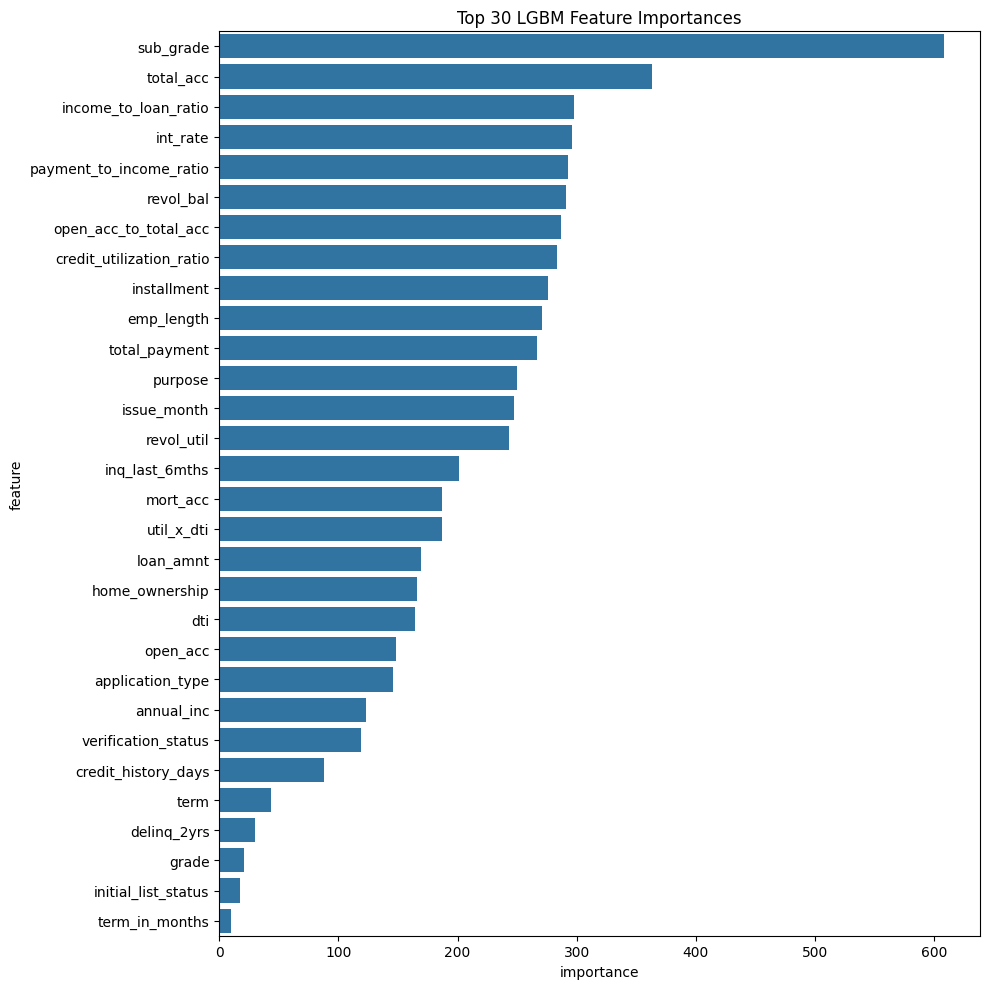

In [23]:
# --- NEW: Feature Importance Plot (from LGBM) ---
print("\n\n--- LGBM FEATURE IMPORTANCE ---")

importances = lgbm.feature_importances_
feature_names = X_train_gb.columns

# Create a DataFrame
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot top 30
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30))
plt.title('Top 30 LGBM Feature Importances')
plt.tight_layout()
plt.savefig('lgbm_feature_importance.png')
plt.show()



--- CALIBRATION & THRESHOLD TUNING (LGBM) ---
Calibrating LightGBM model...
Calibration complete.

Finding optimal threshold for F1-Score...
Best F1 Score on Test Set: 0.2109
Optimal Threshold for F1: 0.1070

--- Classification Report with Tuned Threshold (LGBM) ---
                precision    recall  f1-score   support

Fully Paid (0)       0.96      0.87      0.91     10840
   Default (1)       0.15      0.37      0.21       668

      accuracy                           0.84     11508
     macro avg       0.55      0.62      0.56     11508
  weighted avg       0.91      0.84      0.87     11508

Tuned Confusion Matrix:


c:\Users\amans\Desktop\FODS PROJECT\fods\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


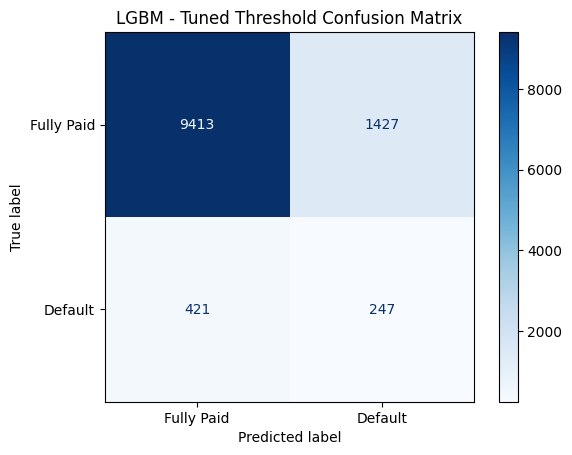

In [24]:
# --- 8. Calibration & Threshold Tuning (on best model) ---
print("\n\n--- CALIBRATION & THRESHOLD TUNING (LGBM) ---")
# Using LGBM as it's typically the best and fastest
print("Calibrating LightGBM model...")
calibrated_lgbm = CalibratedClassifierCV(lgbm, cv="prefit", method='isotonic')
calibrated_lgbm.fit(X_test_gb, y_test) # Calibrate on test set
print("Calibration complete.")

print("\nFinding optimal threshold for F1-Score...")
y_pred_proba = calibrated_lgbm.predict_proba(X_test_gb)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_f1 = np.max(f1_scores[:-1])
best_threshold = thresholds[np.argmax(f1_scores[:-1])]

print(f"Best F1 Score on Test Set: {best_f1:.4f}")
print(f"Optimal Threshold for F1: {best_threshold:.4f}")

y_pred_tuned = (y_pred_proba >= best_threshold).astype(int)
print("\n--- Classification Report with Tuned Threshold (LGBM) ---")
print(classification_report(y_test, y_pred_tuned, target_names=['Fully Paid (0)', 'Default (1)']))

print("Tuned Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned,
                                      cmap='Blues',
                                      display_labels=['Fully Paid', 'Default'])
plt.title("LGBM - Tuned Threshold Confusion Matrix")
plt.savefig('evaluation_lgbm_tuned.png')
plt.show()



--- MODEL EXPLAINABILITY (SHAP) ---


Creating SHAP explainer...
Calculating SHAP values for a sample...
SHAP Global Feature Importance (Bar Plot)


c:\Users\amans\Desktop\FODS PROJECT\fods\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


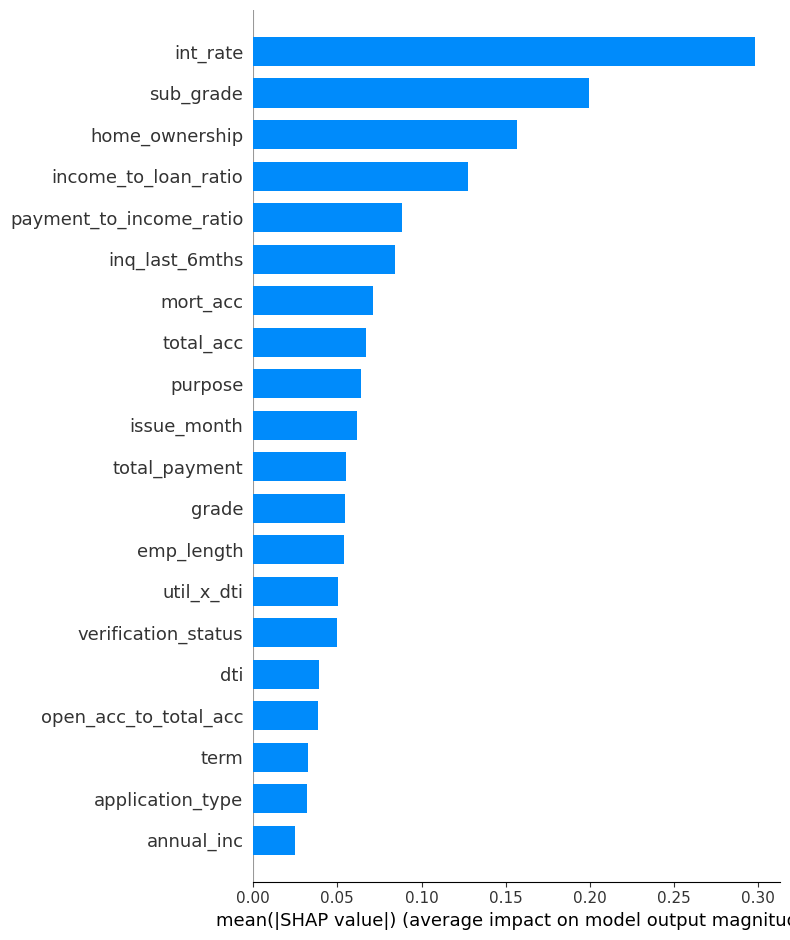


SHAP Global Feature Importance (Summary/Dot Plot)


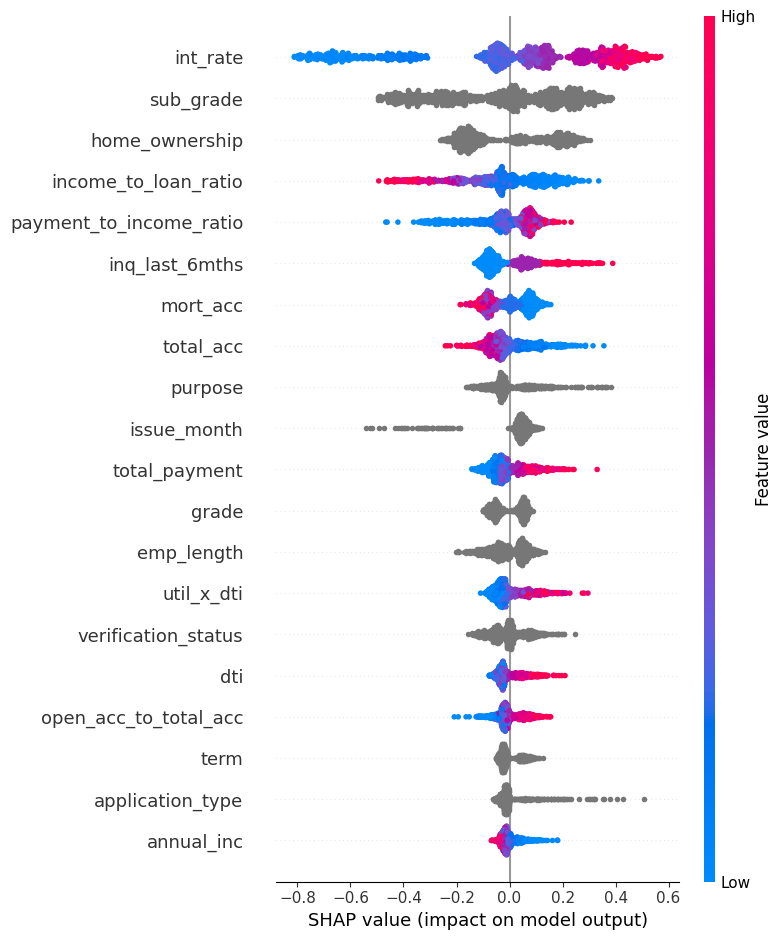


SHAP Local Explanation (Waterfall Plot for first test sample)


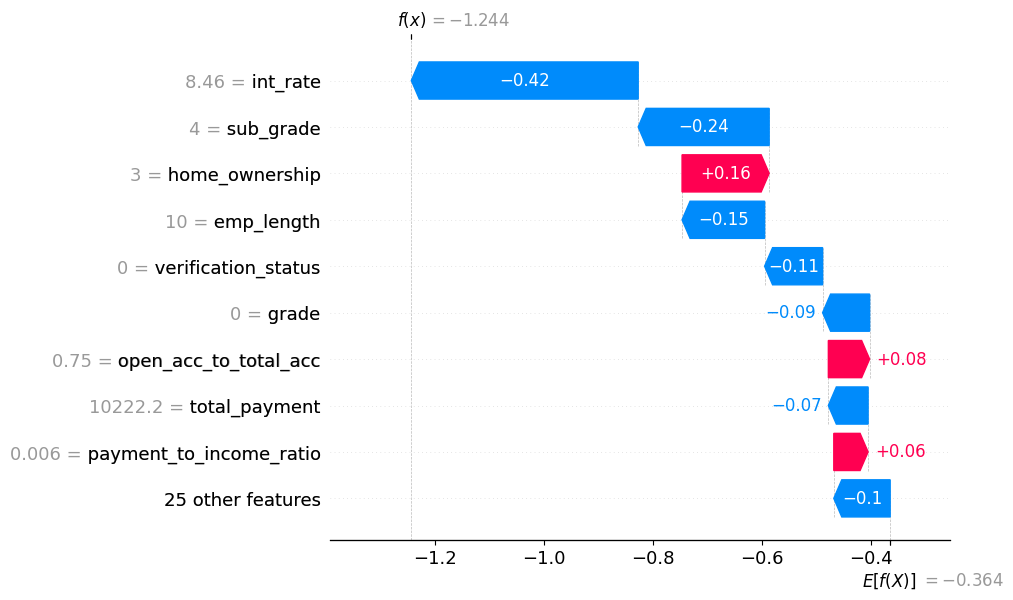

In [ ]:
# --- 9. Model Explainability (SHAP) ---
print("\n\n--- MODEL EXPLAINABILITY (SHAP) ---")
try:
    shap.initjs()
    print("Creating SHAP explainer...")
    explainer = shap.TreeExplainer(lgbm) # Use the uncalibrated model
    
    print("Calculating SHAP values for a sample...")
    # SHAP can be slow, so we sample the test set
    X_test_sample = X_test_gb.sample(n=1000, random_state=42)
    
    # Use .shap_values() which is more explicit for binary classification
    shap_values_list = explainer.shap_values(X_test_sample)
    
    # Check if we got a list (binary classification) or a single array
    if isinstance(shap_values_list, list) and len(shap_values_list) == 2:
        shap_values_class_1 = shap_values_list[1] # Values for the positive class (1)
    else:
        shap_values_class_1 = shap_values_list # Assume it's already for the positive class
        
    # Check if expected_value is a list/array or a single scalar
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        expected_value_class_1 = explainer.expected_value[1] # Base value for the positive class (1)
    else:
        expected_value_class_1 = explainer.expected_value # It's a single scalar value

    print("SHAP Global Feature Importance (Bar Plot)")
    # Use the shap_values_class_1 array directly
    shap.summary_plot(shap_values_class_1, X_test_sample, plot_type="bar", show=False)
    plt.savefig('shap_bar_plot.png')
    plt.show()

    print("\nSHAP Global Feature Importance (Summary/Dot Plot)")
    shap.summary_plot(shap_values_class_1, X_test_sample, show=False)
    plt.savefig('shap_summary_plot.png')
    plt.show()

    print("\nSHAP Local Explanation (Waterfall Plot for first test sample)")
    # Create the Explanation object correctly
    shap.waterfall_plot(shap.Explanation(
        values=shap_values_class_1[0,:],
        base_values=expected_value_class_1,
        data=X_test_sample.iloc[0,:],
        feature_names=X_test_sample.columns.tolist()
    ), show=False)
    plt.savefig('shap_waterfall_plot.png')
    plt.show()

except Exception as e:
    print(f"SHAP visualization failed. This can happen in some environments. Error: {e}")

In [28]:
# --- 10. Deployment Artifacts ---
print("\n\n--- SAVING DEPLOYMENT ARTIFACTS ---")
# 1. Save the best model (using the calibrated one)
joblib.dump(calibrated_lgbm, 'lgbm_calibrated_model.joblib')

# 2. Save Imputation Values (from X_train, before GB processing)
# (imputation_values was created in the preprocessing cell)
joblib.dump(imputation_values, 'imputation_values.joblib')

# 3. Save Feature Lists
joblib.dump(categorical_features_for_boost, 'categorical_features.joblib')
joblib.dump(X_train_gb.columns.tolist(), 'feature_columns.joblib')

# 4. Save the Label Encoders (NEWLY ADDED)
joblib.dump(label_encoders, 'label_encoders.joblib')

# 5. Save the SHAP Explainer (create from the *uncalibrated* model)
print("Creating and saving full SHAP explainer for deployment...")
full_explainer = shap.TreeExplainer(lgbm) # Use the uncalibrated lgbm
joblib.dump(full_explainer, 'shap_explainer.joblib')

print("All artifacts saved to disk: \n- lgbm_calibrated_model.joblib \n- imputation_values.joblib \n- categorical_features.joblib \n- feature_columns.joblib \n- label_encoders.joblib \n- shap_explainer.joblib")



--- SAVING DEPLOYMENT ARTIFACTS ---
Creating and saving full SHAP explainer for deployment...
All artifacts saved to disk: 
- lgbm_calibrated_model.joblib 
- imputation_values.joblib 
- categorical_features.joblib 
- feature_columns.joblib 
- label_encoders.joblib 
- shap_explainer.joblib
